# Building minimum water availability suitablity layers for GRIDCERF

The following code was used to build the water availability suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.


## 1. Downloading the data

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Download the available water data


- **Title**:  Surface Water Flow
- **Description from Source**:   This data is a representation of stream and river water bodies derived from the National Hydrography Dataset (NHD) and is symbolized by flow rate from gauge adjusted values from the USGS Extended Unit Runoff Method(EROM) table. The EROM table contains other mean annual flow/velocity statistics for the NHDFlowline features such as Flow from runoff or Velocity from runoff. Subject matter experts on this data agreed that for the purposes of finding flow discharge rates of cooling water for power plants, the gauge adjusted vales were the ideal empirical values for this study. It should also be noted that the flow rates were originally in Cubic feet per second (cfs) but converted to Gallons per minute (gpm).  The geospatial data sets included in NHDPlusV2 are intended to support a variety of water- related applications. They already have been used in an application to develop estimates of mean annual streamflow and velocity for each NHDFlowline feature in the conterminous United States. The results of these analyses are included with the NHDPlusV2 data. A water-quality model developed by the U.S. Geological Survey (USGS) called SPARROW (Spatially Referenced Regressions on Watershed Attributes), can utilize the NHDPlusV2 network functionality to track the downstream transport of nutrients, sediments, or other substances. NHDPlusV2 water bodies and estimates of streamflow and velocity are used in SPARROW to identify reservoir retention and in-stream loss factors. NHDPlusV2 climatic and land surface attributes can be used in SPARROW to identify potential factors in the delivery of nutrients from the land surface to streams. NHDPlusV2 data is also being used in select areas for a USGS Web-based application, called StreamStats. StreamStats provides tools to interactively select any point in the implemented areas, delineate watersheds, and to obtain streamflow and watershed characteristics for the selected point. NHDPlusV2 has been designed to accommodate many users' needs for future applications. NHDPlusV2 provides the framework and tools necessary to customize the behavior of the network relationships as well as building upon the attribute database, for which the user can assign their own data to the network.
- **Source URL**:  https://ezmt.anl.gov/mapexport/surface_water_flow_nhdplus_v2_erom_eispc_v2.zip
- **Date Accessed**:  10/14/22
- **Citation**
> Moore, R. B. et al. User’s guide for the national hydrography dataset plus (NHDPlus) high resolution: U.S. Geological Survey Open-File Report 2019–1096. https://pubs.er.usgs.gov/publication/ofr20191096 (2019).
> 
- **Application**: The Clean Water Act of 2005 requires all thermoelectric power plants that draw water from natural surface water sources to draw water from sources that meet minimum surface water flow thresholds corresponding to the amount of gallons withdrawn by the plant. The surface water flow data is used to create suitability layers corresponding to a 20km region around surface water sources that meet the corresponding MGD threshold.

__________

- **Title**:  Principal Aquifers of the 48 Conterminous United States, Hawaii, Puerto Rico, and the U.S. Virgin Islands
- **Description from Source**:   This map layer contains the shallowest principal aquifers of the conterminous United States, 
Hawaii, Puerto Rico, and the U.S. Virgin Islands, portrayed as polygons.
- **Source URL**:  https://water.usgs.gov/GIS/dsdl/aquifers_us.zip
- **Date Accessed**:  09/26/23
- **Citation**
> US Geological Survey, 2000. Principal Aquifers of the 48 Conterminous United States, Hawaii, Puerto Rico, and the U.S. Virgin Islands. Ground Water Atlas of the United States. USGS HA-730. https://water.usgs.gov/lookup/getspatial?aquifers_us
> 
- **Application**: For some technologies that require cooling water, it is common to use groundwater if surface water sources are insufficient. For these technologies, a combined suitability layer with both minimum surface water flow and groundwater availability is used. To determine groundwater availability, only geospatial areas located above an aquifer are included. All aquifers are included except for those labeled "Other rocks".

## 2. Setup environment

### 2.1 Install GDAL

This application requires GDAL to be installed.  We will call GDAL directly from your command prompt or terminal, so please ensure that you can do so before running the following cells.  More information on how to install GDAL can be found here:  https://gdal.org/download.html


### 2.3 Import necessary Python packages

In [1]:
import os
import glob

import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features

## 3. Configuration

In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF common data directory
common_dir = os.path.join(gridcerf_dir, "common")

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# source data directory
source_dir = os.path.join(gridcerf_dir, "source", 'technology_specific', "surface_water_flow")
groundwater_source_dir = os.path.join(gridcerf_dir, "source", 'technology_specific', 'groundwater_aquifers')

# temporary output raster for processing
temp_output_raster = os.path.join(source_dir, "temporary_raster.tif")

# generate a list of all common exclusion files
common_raster_list = glob.glob(os.path.join(common_dir, "*.tif"))

# source NHD shapefile
nhd_shapefile = os.path.join(source_dir, "surface_water_flow_nhdplus_v2_erom_eispc_v2", "ez_gis.surface_water_flow_nhdplus_v2_erom_eispc_v2.shp")
aquifer_shapefile = os.path.join(groundwater_source_dir, 'aquifers_us', 'us_aquifers.shp')


# bins for minimum mean annual flow requirements where the key is the target 
#  file name and the value is the threshold in MGD
mgd_list = [2, 5, 10, 15, 20, 25, 35, 40, 55, 70, 75, 95, 110, 120, 145, 200, 700, 1000, 3000, 5000, 7000, 10000, 50000]

# bins for minimum mean annual flow requirements where the key is the target to be used in combination with groundwater availability
combined_mgd_list = [2, 5, 55]

# crs for converting projections
crs = 'ESRI:102003'

## 4. Generate wind suitability rasters

### 4.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)

            # invert suitability
            burned = np.where(burned ==1, 0, 1).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))

In [4]:
def preprocess_nhd_data(nhd_shapefile: str,
                        crs) -> gpd.GeoDataFrame:
    """Preprocess NHD flowlines to convert to millions gallons per day (MGD) and prepare
    a rasterization field.
    
    """
    
    # only keep gallons per minute flow and geometry and reproject
    gdf = gpd.read_file(nhd_shapefile)[['q_gpm', 'geometry']].to_crs(crs)

    # convert to millions gallons per day
    gdf['mgd'] = (gdf['q_gpm'] / 1000000) * 60 * 24

    # drop gpm field
    gdf.drop(columns=['q_gpm'], inplace=True)

    # set raster value
    gdf['value'] = 0
    
    return gdf 
    

In [5]:
# preprocess NHD flowlines for rasterization to MGD thresholds
print("Preprocessing NHD data...")
gdf = preprocess_nhd_data(nhd_shapefile=nhd_shapefile,
                          crs=crs)

Preprocessing NHD data...


### 4.2 Generate available surface water suitability rasters

In [6]:
# create buffered flowlines matching the flow requirement
for i in mgd_list:
    
    print(f"Processing flow threshold of:  {i} MGD")
    
    # construct a file basename
    basename = f"gridcerf_nhd2plus_surfaceflow_greaterthan{i}mgd_buffer20km"
    
    # extract the flowlines that support the minimum flow requirement
    gdx = gdf.loc[gdf['mgd'] >= i].copy()

    # buffer by 20 km (20000 meters)
    gdx['geometry'] = gdx.buffer(20000)

    gdx['value'] = 1

    # construct the water availability raster output raster name
    output_raster = os.path.join(technology_specific_dir, f"{basename}.tif")

    # generate raster for inland flood risk
    vector_to_raster(template_raster=template_raster, 
                     land_mask_raster=template_raster,
                     gdf=gdx, 
                     value_field="value",
                     output_raster=output_raster)

Processing flow threshold of:  2 MGD
Processing flow threshold of:  5 MGD
Processing flow threshold of:  10 MGD
Processing flow threshold of:  15 MGD
Processing flow threshold of:  20 MGD
Processing flow threshold of:  25 MGD
Processing flow threshold of:  35 MGD
Processing flow threshold of:  40 MGD
Processing flow threshold of:  55 MGD
Processing flow threshold of:  70 MGD
Processing flow threshold of:  75 MGD
Processing flow threshold of:  95 MGD
Processing flow threshold of:  110 MGD
Processing flow threshold of:  120 MGD
Processing flow threshold of:  145 MGD
Processing flow threshold of:  200 MGD
Processing flow threshold of:  700 MGD
Processing flow threshold of:  1000 MGD
Processing flow threshold of:  3000 MGD
Processing flow threshold of:  5000 MGD
Processing flow threshold of:  7000 MGD
Processing flow threshold of:  10000 MGD
Processing flow threshold of:  50000 MGD


### 4.3 Generate combined surface and groundwater suitability rasters

#### 4.3.1 Process Aquifer Data

<Axes: >

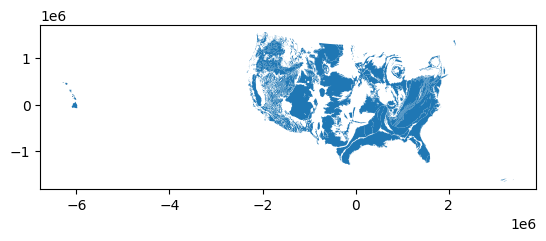

In [7]:
# read in aquifer dataset and convert crs
aquifer_gdf = gpd.read_file(aquifer_shapefile).to_crs(crs)

# remove non aquifer areas
aquifer_gdf = aquifer_gdf[aquifer_gdf.AQ_NAME != 'Other rocks']

aquifer_gdf.plot()

In [8]:
# create buffered flowlines matching the flow requirement
for i in combined_mgd_list:
    
    print(f"Processing flow threshold of:  {i} MGD")
    
    # extract the flowlines that support the minimum flow requirement
    gdx = gdf.loc[gdf['mgd'] >= i].copy()

    # buffer by 20 km (20000 meters)
    gdx['geometry'] = gdx.buffer(20000)

    # combine with groundwater data
    combined_gdf = pd.concat([gdx, aquifer_gdf])

    combined_gdf['value'] = 1

    combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry=combined_gdf['geometry'])

    # construct the water availability raster output raster name
    output_raster = os.path.join(technology_specific_dir, f'gridcerf_usgs_aquifer_nhd2plus_surfaceflow_{i}mgd_buffer20km.tif')

    # generate raster for inland flood risk
    vector_to_raster(template_raster=template_raster, 
                     land_mask_raster=template_raster,
                     gdf=combined_gdf, 
                     value_field="value",
                     output_raster=output_raster)

Processing flow threshold of:  2 MGD
Processing flow threshold of:  5 MGD
Processing flow threshold of:  55 MGD
